# グラフで2バイト文字を使うためのライブラリのインストール

In [ ]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 46.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=d5aa75b8e3319184df180c08b4502d2419f7680f99449bd8a0efcb1b2cef6a52
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


# 乱数シードの固定

In [ ]:
import random
import numpy as np
import os

np.random.seed(0)
random.seed(0)
os.environ["PYTHONHASHSEED"] = str(0)

# 関数 save_fig：図の保存用

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

def save_fig(plt, file_prefix):
    if file_prefix == '':
        return

    parent = os.path.dirname(os.path.abspath(file_prefix))
    os.makedirs(parent, exist_ok=True)
    plt.savefig(f'{file_prefix}.pdf', transparent=True, bbox_inches='tight', pad_inches = 0.2)
    plt.savefig(f'{file_prefix}.png', transparent=True, dpi=300, bbox_inches='tight', pad_inches = 0.2)

# 関数 show_prediction：予測結果の可視化

In [ ]:
def show_prediction(x, y_true, y_pred, ids, file_prefix=''):
    '''
    手書き数字の認識結果を表示する。

    Parameters
    ------------
    model : Sequential
        ニューラルネットワーク・モデル
    '''
    img = x[ids].reshape((len(ids), 28, 28))

    labels = y_true[ids]
    preds = y_pred[ids]

    # AIが認識した結果を画像と一緒に提示する
    plt.figure(2, figsize=(12, 8))
    plt.gray()
    for i in range(len(ids)):
        plt.subplot(8, 12, i + 1)
        plt.pcolor(img[i])
        plt.text(22, 25.5, "%d" % preds[i], fontsize=12, color='yellow')
        if preds[i] != labels[i]:
            plt.plot([0, 27], [1, 1], color='red', linewidth=5)

        plt.xlim(0, 27)
        plt.ylim(27, 0)
        plt.xticks([], '')
        plt.yticks([], '')

    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 evaluate：性能評価関数

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns

def evalulate(x, y_true, y_pred, file_prefix=''):

    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    print('正解率')
    print(f' {accuracy:.2f}')

    class_labels = []

    num_classes = np.max(y_true) + 1
    for i in range(num_classes):
        class_labels.append(f'{i:4d}')

    precision_str = []
    recall_str = []
    for i in range(num_classes):
        precision_str.append(f'{precision[i]:.2f}')
        recall_str.append(f'{recall[i]:.2f}')

    print('精度')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(precision_str))

    print('再現率')
    print(' ' + ' '.join(class_labels))
    print(' ' + ' '.join(recall_str))

    plt.figure(figsize = (10,7))
    sns.heatmap(cm, annot=True, fmt='3d', square=True, cmap='hot')
    plt.tight_layout()
    save_fig(plt, file_prefix=file_prefix)
    plt.show()

# 関数 show_history：学習過程の可視化

In [ ]:
def show_history(history, file_prefix=''):
    plt.figure(figsize=(16, 8))
    plt.subplots_adjust(wspace=0.2)

    # 学習曲線の表示
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'black', label='Training')
    plt.plot(history.history['val_loss'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('損失', fontsize=16)
    plt.ylim(0, )
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    # 正解率表示
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], 'black', label='Training')
    plt.plot(history.history['val_accuracy'], 'cornflowerblue', label='Test')
    plt.legend(fontsize=16)
    plt.xlabel('エポック', fontsize=16)
    plt.title('正解率', fontsize=16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.ylim(0, 1.2)
    plt.grid(True)

    save_fig(plt, file_prefix)

    plt.show()

# 実習8.1：MNISTデータ

訓練データ
形状： (60000, 28, 28)
画像枚数： 60000
画像の縦方向画素数： 28
画像の横方向画素数： 28
テストデータ
形状： (10000, 28, 28)
画像枚数： 10000
画像の縦方向画素数： 28
画像の横方向画素数： 28


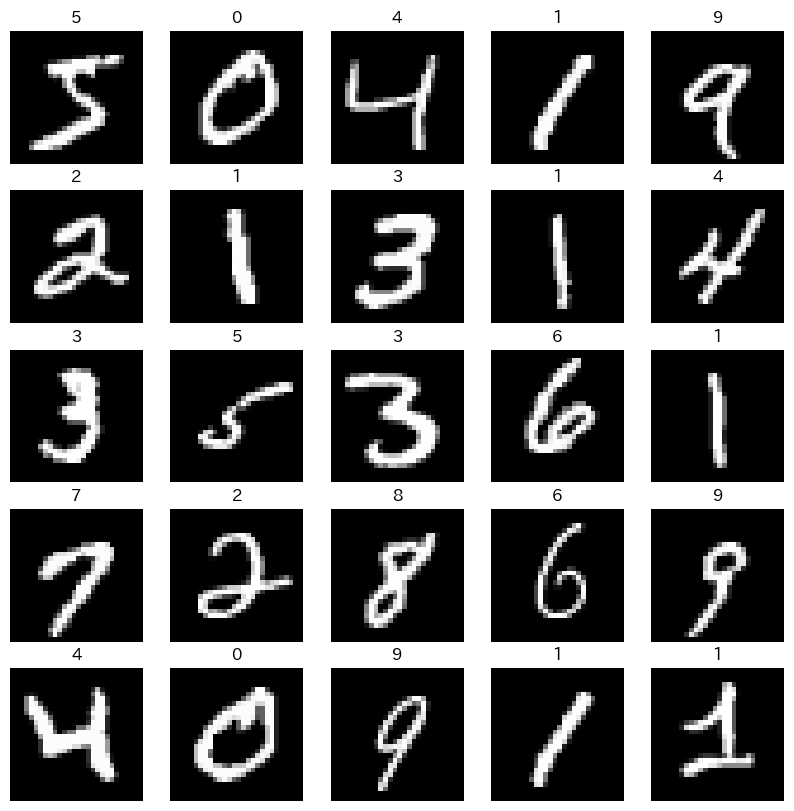

In [ ]:
from tensorflow.keras.datasets import mnist
import numpy as np

# NMISTデータセットをTensorflowのサイトからロード
# （訓練データ画像,　訓練データ・クラスラベル）,（テストデータ画像,　テストデータ・クラスラベル）
(x_train,y_train),(x_test,y_test)=mnist.load_data()

print('訓練データ')
print('形状：', x_train.shape) # (60000, 28, 28) = (枚数, 高さ, 幅)
print('画像枚数：', len(x_train))
# 先頭の画像を取り出す。x_train[0]は2次元配列。形状(高さ,幅)をshapeプロパティで取得
ny,nx=x_train[0].shape
print('画像の縦方向画素数：',ny)
print('画像の横方向画素数：',nx)

print('テストデータ')
print('形状：', x_test.shape)
print('画像枚数：', len(x_test))
ny,nx=x_test[0].shape
print('画像の縦方向画素数：',ny)
print('画像の横方向画素数：',nx)
plt.figure(figsize=(10,10))
N=25 # 表示する画像枚数
for i in range(N):
    plt.subplot(5,5,i+1)
    plt.imshow(x_train[i],cmap='gray')
    plt.title(y_train[i])
    plt.axis('off')

plt.show()

# 実習8.2：各クラスの画像枚数

In [ ]:
# クラスラベルは0～9。
# その最大値は9。クラス数は10。
num_classes=np.max(y_train)+1
print('訓練データのクラス数：', num_classes)

for i in range(num_classes):
    # y_train==i: y_trainの各要素の値がクラスiに等しいか判定
    # 等しい（True）要素の個数をnp.sumで集計
    n=np.sum(y_train==i)
    print(i,n)

num_classes=np.max(y_test)+1
print('テストデータのクラス数：', num_classes)
for i in range(num_classes):
    n=np.sum(y_test==i)
    print(i,n)

訓練データのクラス数： 10
0 5923
1 6742
2 5958
3 6131
4 5842
5 5421
6 5918
7 6265
8 5851
9 5949
テストデータのクラス数： 10
0 980
1 1135
2 1032
3 1010
4 982
5 892
6 958
7 1028
8 974
9 1009


# 実習8.3：教師データを準備する関数を実装

In [ ]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

def load_mnist():
    """手書きデータセットMNISTを教師データとして用意する。
    Returns:
        x_train (ndarray): 訓練データの画像配列。形状(60000, 784)
        y_train (ndarray): 訓練データのクラスラベル。one-hotベクトル化済み。形状(60000, 10)
        x_tes (ndarray): テストデータの画像配列。形状(10000, 784)
        y_test (ndarray): テストデータのクラスラベル。one-hotベクトル化済み。形状(10000, 10)
        ny (int): 画像の縦方向画素数
        nx (int): 画像の横方向画素数
        num_classes (int): クラス数
    """
    (x_train,y_train),(x_test,y_test)=mnist.load_data()

    ny,nx=x_train[0].shape # 実習8.2
    # 訓練データ数 60000。1つの画像は 28 x 28 = 784画素
    # 0から59999の各行には1個の画像が格納されている。
    # 全結合層へ入力するため、各画像をny * nx個の成分を持つ1次元配列へ変換。
    x_train = x_train.reshape(-1, ny*nx)
    x_train = x_train.astype('float32') # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_train=x_train/255

    # クラスラベルをone-hotベクトル化
    num_classes=np.max(y_train)+1
    y_train=to_categorical(y_train,num_classes)
    print('訓練データのクラスラベル形状：', y_train.shape)

    # テストデータの準備。テストデータ数 10000
    # 訓練データと同様に1次元配列へ変換
    x_test = x_test.reshape(-1, ny*nx)
    x_test = x_test.astype('float32') # 要素値の型をfloat32へ変更
    # 画素値の最大値255を使い、画像の値を0以上1以下の範囲にする（正規化）
    x_test=x_test/255

    # クラスラベルをone-hotベクトル化
    num_classes=np.max(y_test)+1
    y_test=to_categorical(y_test,num_classes)
    print('テストデータのクラスラベル形状：', y_test.shape)

    return x_train, y_train, x_test, y_test, nx, ny, num_classes

# 動作確認用
x_train, y_train, x_test, y_test, nx, ny, num_classes = load_mnist()

訓練データのクラスラベル形状： (60000, 10)
テストデータのクラスラベル形状： (10000, 10)


# 実習8.4：1層の中間層をもつmodel1の構築

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 教師データを再生成
x_train, y_train, x_test, y_test, nx, ny, num_classes = load_mnist()

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

model1=Sequential() # モデル（ネットワークの容れ物）を生成

# 中間層
model1.add(Dense(input_dim=ny*nx,      # 入力層のニューロン数
                 units=3,              # 中間層のニューロン数
                 activation='sigmoid', # 中間層の活性化関数（シグモイド）
                 name='hidden1'))      # 中間層の名前

# 出力層
model1.add(Dense(units=num_classes,    # 出力層のニューロン数
                 activation='softmax', # 出力層の活性化関数（ソフトマックス）
                 name='output'))       # 出力層の名前

# 損失関数と最適化手法の設定
model1.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model1.summary()

訓練データのクラスラベル形状： (60000, 10)
テストデータのクラスラベル形状： (10000, 10)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 3)                 2355      
                                                                 
 output (Dense)              (None, 10)                40        
                                                                 
Total params: 2,395
Trainable params: 2,395
Non-trainable params: 0
_________________________________________________________________


# 実習8.5：model1の学習

In [ ]:
# 学習開始。終了後、学習の履歴がhistory1に代入される
history1=model1.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
60/60 [==============================] - 5s 8ms/step - loss: 2.3124 - accuracy: 0.0989 - val_loss: 2.2953 - val_accuracy: 0.0990
Epoch 2/500
60/60 [==============================] - 0s 5ms/step - loss: 2.2850 - accuracy: 0.0899 - val_loss: 2.2744 - val_accuracy: 0.0861
Epoch 3/500
60/60 [==============================] - 0s 5ms/step - loss: 2.2671 - accuracy: 0.0833 - val_loss: 2.2584 - val_accuracy: 0.0832
Epoch 4/500
60/60 [==============================] - 0s 5ms/step - loss: 2.2520 - accuracy: 0.1001 - val_loss: 2.2438 - val_accuracy: 0.1268
Epoch 5/500
60/60 [==============================] - 0s 5ms/step - loss: 2.2376 - accuracy: 0.1572 - val_loss: 2.2296 - val_accuracy: 0.1869
Epoch 6/500
60/60 [==============================] - 0s 6ms/step - loss: 2.2236 - accuracy: 0.2074 - val_loss: 2.2157 - val_accuracy: 0.2252
Epoch 7/500
60/60 [==============================] - 0s 6ms/step - loss: 2.2101 - accuracy: 0.2398 - val_loss: 2.2023 - val_accuracy: 0.2509
Epoch 8/500
6

# 実習8.6：model1の学習の履歴と汎化能力の推定

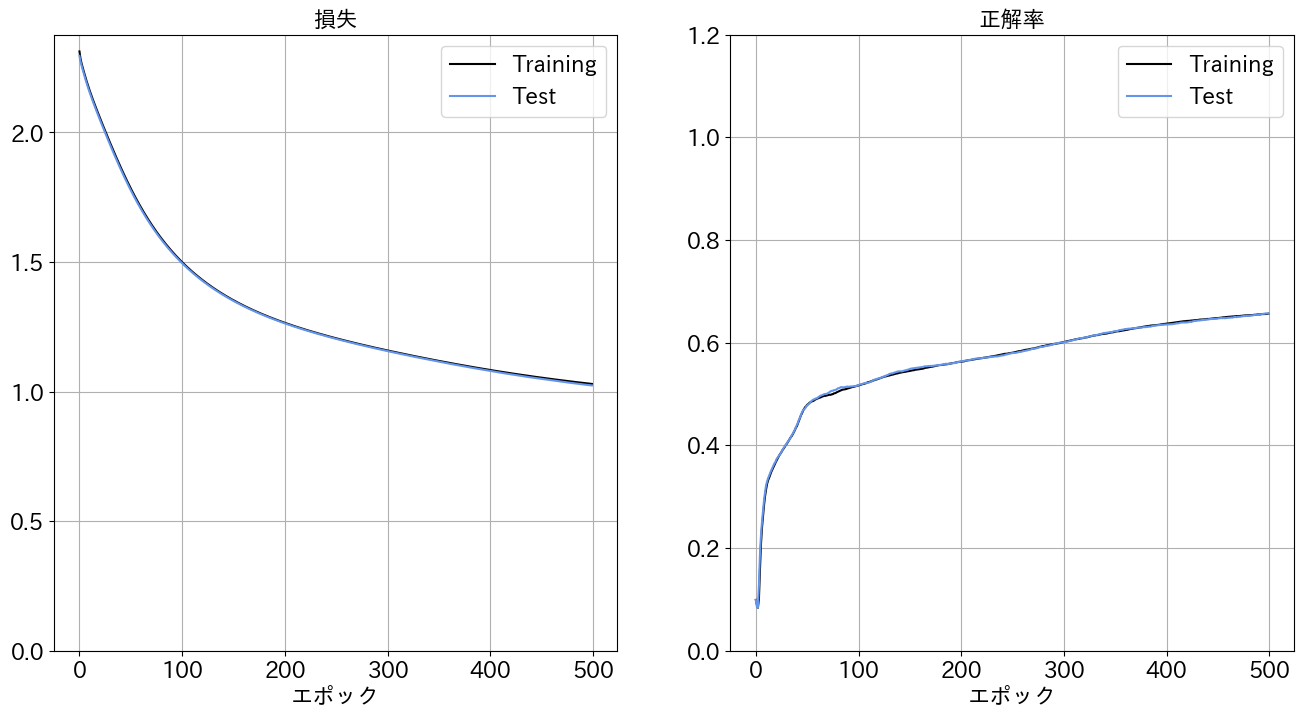

正解率
 0.66
精度
    0    1    2    3    4    5    6    7    8    9
 0.79 0.85 0.26 0.60 0.77 0.67 0.40 0.82 0.55 0.72
再現率
    0    1    2    3    4    5    6    7    8    9
 0.94 0.96 0.06 0.69 0.71 0.60 0.85 0.81 0.23 0.69


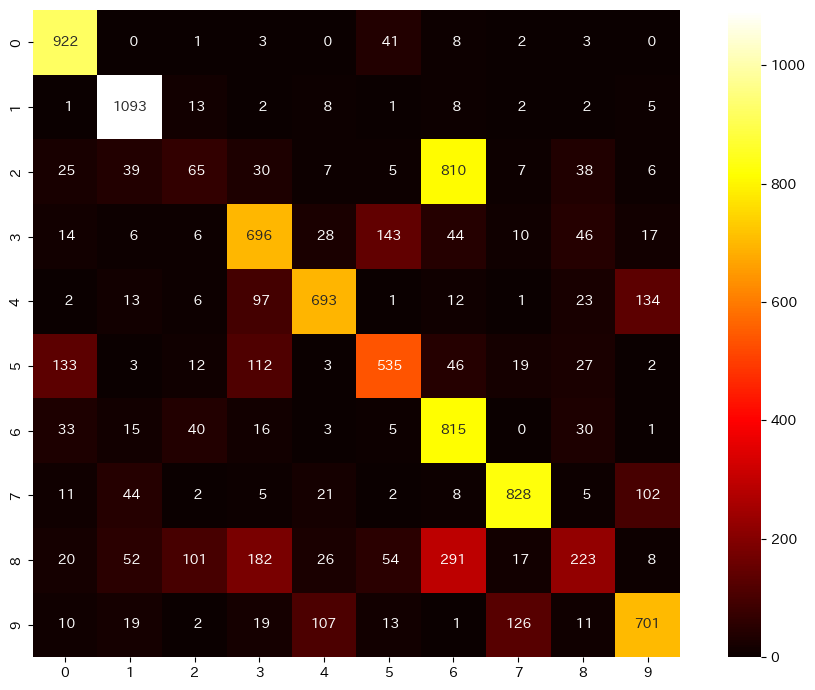

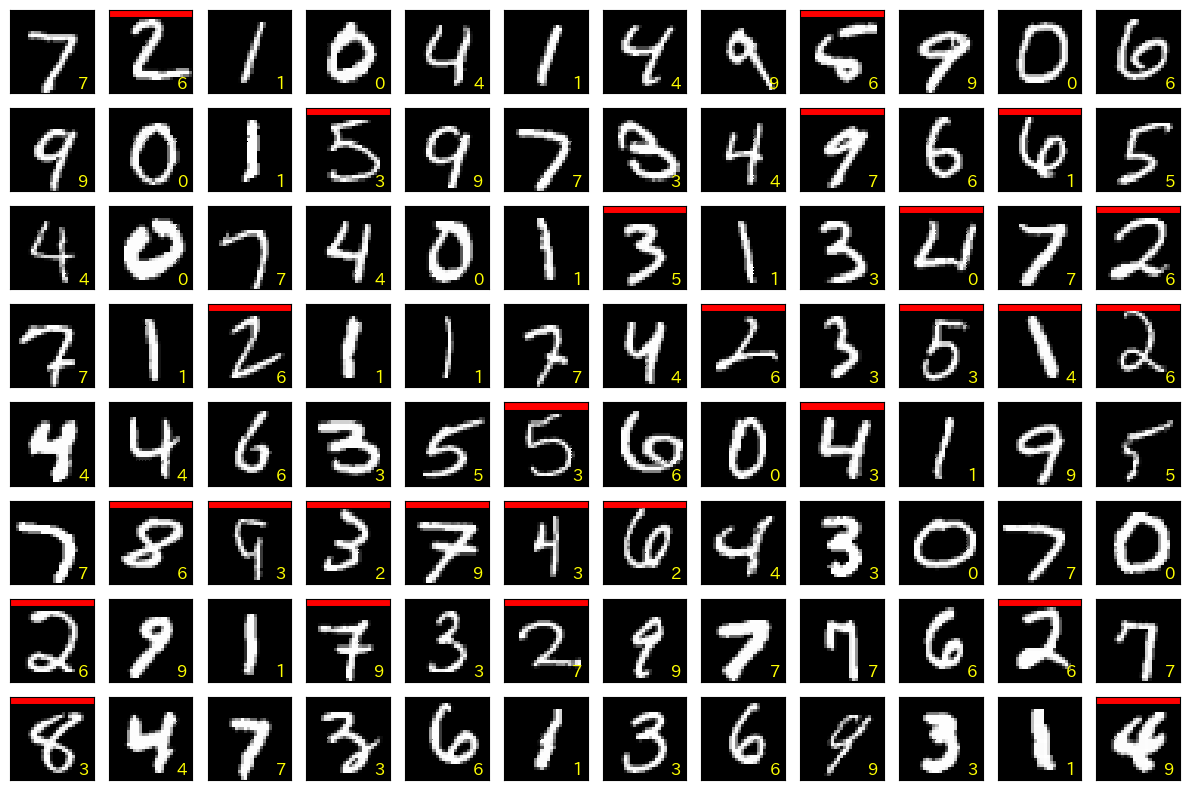

In [ ]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history1)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model1.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evalulate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids)

# 実習8.7：10層の中間層を持つmodel2を構築

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 教師データを再生成
x_train, y_train, x_test, y_test, nx, ny, num_classes = load_mnist()

# ネットワークのパラメータ（重みとバイアス）を初期化する際の乱数シードを固定
tf.random.set_seed(0)

n_hidden=10 # 中間層数


model2=Sequential() # ネットワークモデルを生成。層（レイヤー）の容器と考える。

# 最初の中間層を追加
model2.add(Dense(input_dim=ny*nx,      # 入力層のニューロン数
                 units=10,             # 中間層のニューロン数
                 activation='sigmoid', # 中間層の活性化関数（シグモイド）
                 name='hidden1'))      # 中間層の名前
# 2から9番目の中間層を追加
for i in range(2,n_hidden+1):
    model2.add(Dense(units=10,
                     activation='sigmoid',
                     name=f'hidden{i}'))

# 出力層を追加
model2.add(Dense(units=10,
                 activation='softmax',
                 name='output'))

model2.compile(optimizer='SGD',                 # パラメータの最適化手法にAdamを指定
               loss='categorical_crossentropy', # 損失関数
               metrics=['accuracy'])            # 損失の他にモニターする指標として正解率を指定

# モデルの要約情報を表示
model2.summary()

訓練データのクラスラベル形状： (60000, 10)
テストデータのクラスラベル形状： (10000, 10)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden1 (Dense)             (None, 10)                7850      
                                                                 
 hidden2 (Dense)             (None, 10)                110       
                                                                 
 hidden3 (Dense)             (None, 10)                110       
                                                                 
 hidden4 (Dense)             (None, 10)                110       
                                                                 
 hidden5 (Dense)             (None, 10)                110       
                                                                 
 hidden6 (Dense)             (None, 10)                110       
                                                               

# 実習8.8：model2の学習

In [ ]:
# 学習開始。終了後、学習の履歴がhistory2に代入される
history2=model1.fit(x_train, # 訓練データ：入力画像
                    y_train, # 訓練データ：クラスラベル
                    epochs=500, # エポック数
                    batch_size=1000, # バッチサイズ
                    shuffle=True,    # 学習時にデータの並びをシャッフル
                    validation_data=(x_test,y_test)) # 学習過程での汎化能力の推定のためテストデータを指定

Epoch 1/500
60/60 [==============================] - 0s 6ms/step - loss: 1.0290 - accuracy: 0.6567 - val_loss: 1.0230 - val_accuracy: 0.6573
Epoch 2/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0286 - accuracy: 0.6569 - val_loss: 1.0225 - val_accuracy: 0.6578
Epoch 3/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0281 - accuracy: 0.6570 - val_loss: 1.0220 - val_accuracy: 0.6578
Epoch 4/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0277 - accuracy: 0.6572 - val_loss: 1.0216 - val_accuracy: 0.6582
Epoch 5/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0272 - accuracy: 0.6572 - val_loss: 1.0212 - val_accuracy: 0.6581
Epoch 6/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0268 - accuracy: 0.6573 - val_loss: 1.0206 - val_accuracy: 0.6584
Epoch 7/500
60/60 [==============================] - 0s 5ms/step - loss: 1.0264 - accuracy: 0.6574 - val_loss: 1.0202 - val_accuracy: 0.6582
Epoch 8/500
6

# 実習8.9：model2の学習の履歴と汎化能力の推定

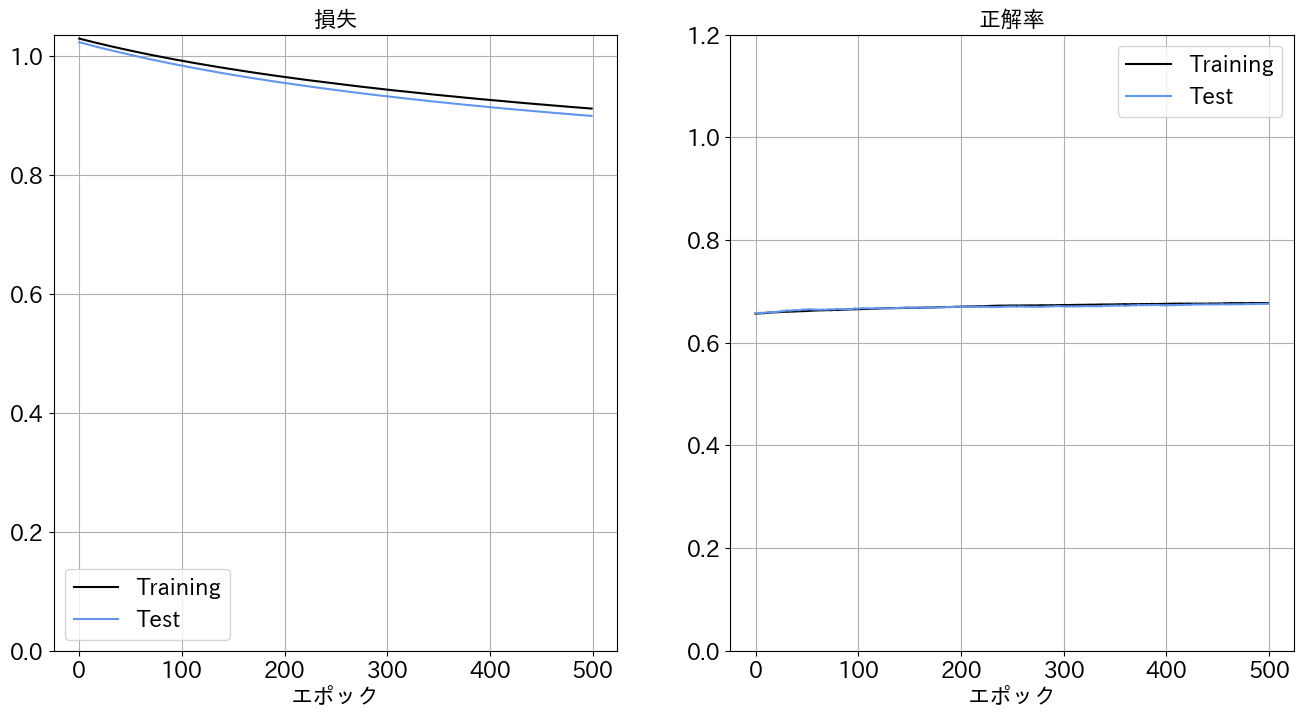

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


正解率
 0.10
精度
    0    1    2    3    4    5    6    7    8    9
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.10 0.00 0.00
再現率
    0    1    2    3    4    5    6    7    8    9
 0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00


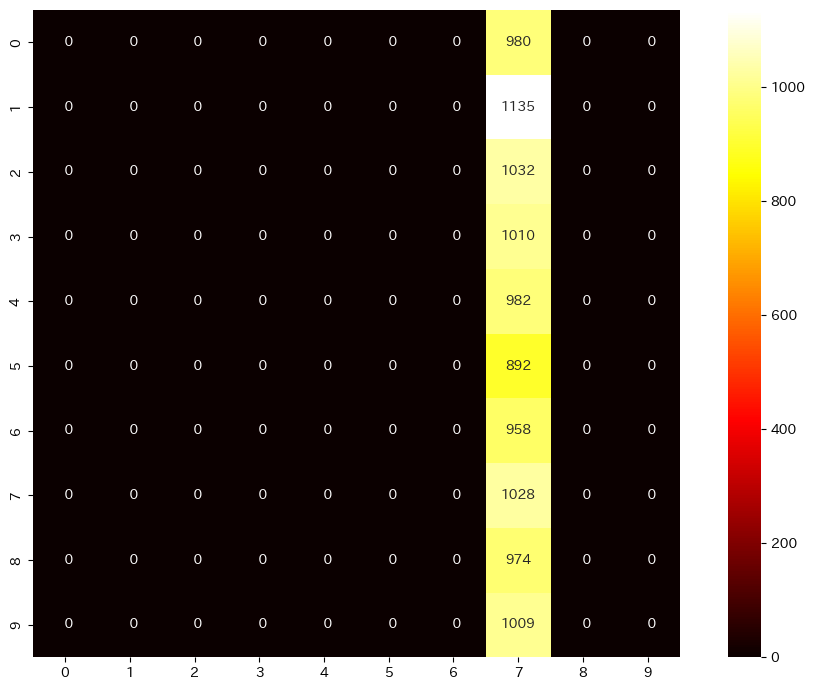

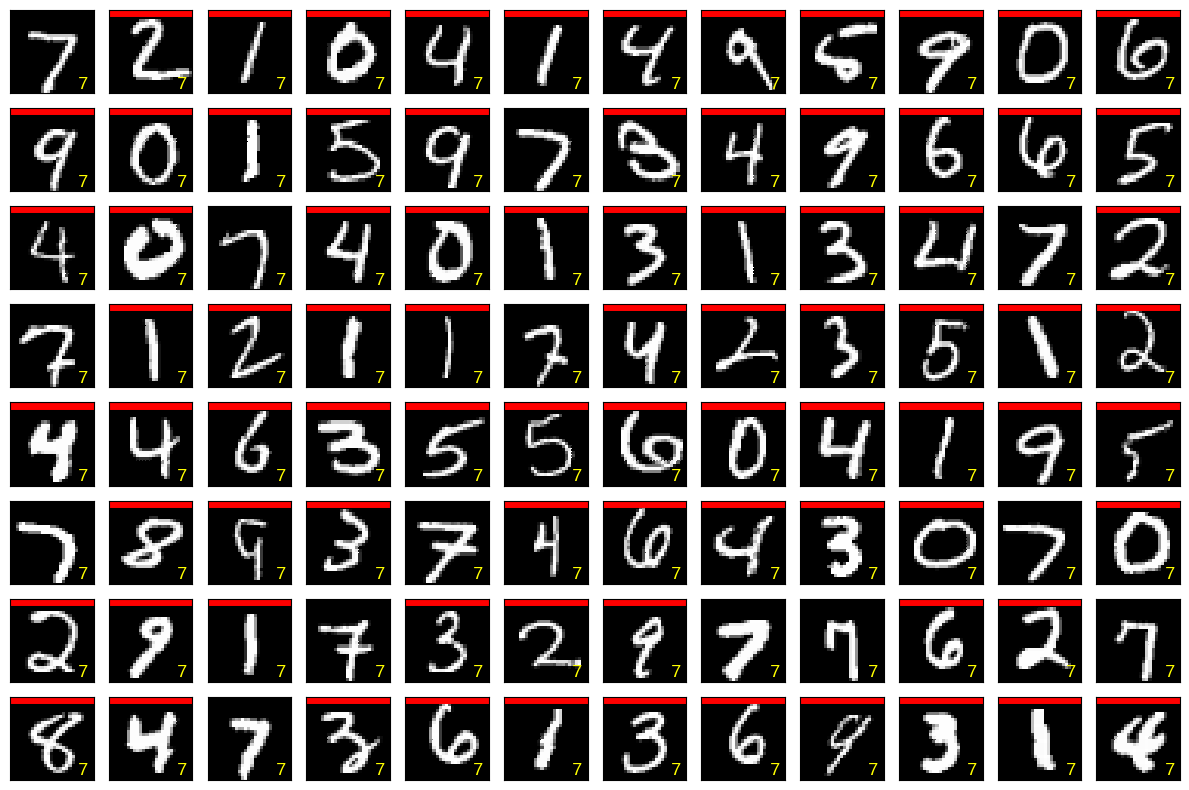

In [ ]:
# 学習の履歴（損失と正解率の変化）を表示
show_history(history2)

# 学習したモデルを使い、テストデータのクラスラベルを予測
y_pred=model2.predict(x_test, verbose=0)

# 各データについて、最大の予測確率を持つクラスラベルを取得
y_pred=np.argmax(y_pred, axis=1)

# 正解（one-hotベクトル）をクラスラベルに戻す
y_true=np.argmax(y_test, axis=1)

# 混同行列、正解率、精度、再現率を評価
evalulate(x_test,y_true,y_pred)

# 予測結果の一部を可視化する
ids=range(96) # 可視化するデータの番号0から95

# データの番号0から95について、予測結果を可視化
show_prediction(x_test,y_true,y_pred,ids)